# Toy FNO Model
Predicting the evolution of a velocity field

In [3]:
TEST_MODE = True
num_train_samples = 200 # total: 36k
num_test_samples = 20 # total: 4k

In [7]:
import torch
from neuralop.models.fno import FNO
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json
import os
import wandb

In [8]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: sreeyutha-ratala (sreeyutha-ratala-caltech). Use `wandb login --relogin` to force relogin


True

In [10]:
# set parameters
epochs = 10 # TODO CHANGE!
learning_rate = 0.001 #initial
batch_size = 16

In [11]:
# monitor model's progress
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="toy-fno",

    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "FNO",
    "dataset": "toy FNO dataset",
    "epochs": epochs,
    "batch_size": batch_size
    }
)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [15]:
# save model
checkpoint_dir = './checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

In [16]:
# load data
data = torch.load('./Data.pt')
train_input = data["train_in"]
train_output = data["train_sol"]
test_input = data["test_in"]
test_output = data["test_sol"]

In [17]:
print(train_input.shape)  # (N, 2, 64, 64)
print(test_output.shape)  # (N, 2, 64, 64)

torch.Size([36000, 2, 64, 64])
torch.Size([4000, 2, 64, 64])


In [18]:
train_input = train_input[:num_train_samples]
train_output = train_output[:num_train_samples]
test_input = test_input[:num_test_samples]
test_output = test_output[:num_test_samples]

In [19]:
# define and instantiate: loss and model
class L2Loss(object): # L2 norm on functions (normalize by number of grid points)
    # loss returns the sum over all the samples in the current batch
    def __init__(self,):
        super(L2Loss, self).__init__()
    
    def __call__(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), 2, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), 2, 1)
        return torch.sum(diff_norms / y_norms)

#           fourier transform: freq modes                        x & y component of vector field
model = FNO(n_modes=(16, 16), hidden_channels=64, in_channels=2, out_channels=2) # discretization invariant (uniform grid)
model.to(device)
criterion = L2Loss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Adjust lr every 50 epochs by multiplying with gamma; cos scheduler

In [20]:
train_dataset = TensorDataset(train_input, train_output)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_input, test_output)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
# train and test model at each epoch
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss / num_train_samples
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    epoch_test_loss = val_loss / num_test_samples
    test_losses.append(epoch_test_loss)
    
    scheduler.step()  # Update learning rate scheduler
    
    wandb.log({"epoch": epoch, "train_loss": epoch_train_loss, "test_loss": epoch_test_loss, "learning_rate": optimizer.param_groups[0]['lr']}) # log metrics to wandb


    if TEST_MODE:
        print(f"Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
    #else: # Save checkpoint
        if (epoch + 1) % 10 == 0:  # Save every 10 epochs
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'test_losses': test_losses,
            }, checkpoint_path)
            # save model checkpoint to wandb
            artifact = wandb.Artifact('model-checkpoints', type='model')
            artifact.add_file(checkpoint_path)
            wandb.log_artifact(artifact)
            print(f'Saved checkpoint at epoch {epoch+1}')

Epoch 1, Train Loss: 0.0648, Test Loss: 0.1532
Epoch 2, Train Loss: 0.0631, Test Loss: 0.1530
Epoch 3, Train Loss: 0.0623, Test Loss: 0.1509
Epoch 4, Train Loss: 0.0621, Test Loss: 0.1518
Epoch 5, Train Loss: 0.0603, Test Loss: 0.1522
Epoch 6, Train Loss: 0.0600, Test Loss: 0.1525
Epoch 7, Train Loss: 0.0606, Test Loss: 0.1503
Epoch 8, Train Loss: 0.0623, Test Loss: 0.1539
Epoch 9, Train Loss: 0.0602, Test Loss: 0.1563
Epoch 10, Train Loss: 0.0602, Test Loss: 0.1546
Saved checkpoint at epoch 10


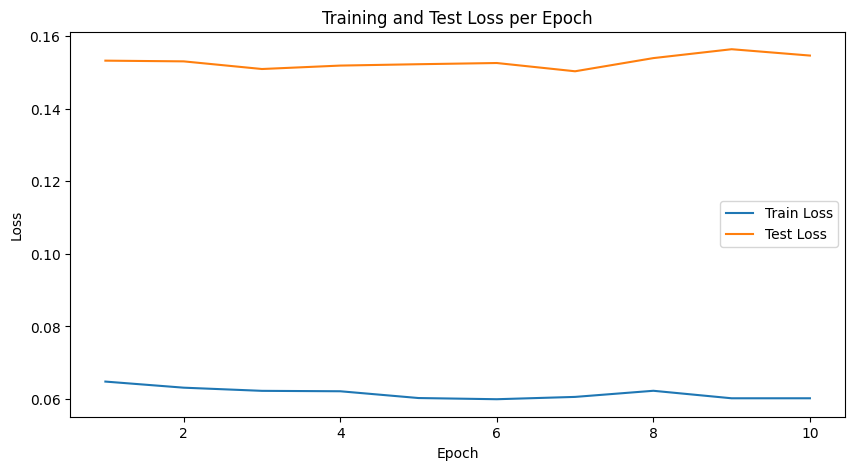

In [23]:
# Plot train and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
if not TEST_MODE:
    plt.savefig('train_test_loss_per_epoch')
else:
    plt.show()

# TODO: modifying hyperparameters: n_modes, width, epochs, learning_rate, batch_size. Grid search?

In [24]:
# Save the losses to a file
if not TEST_MODE:
    losses = {
        'train_losses': train_losses,
        'test_losses': test_losses
    }
    with open('losses.json', 'w') as f:
        json.dump(losses, f)

In [25]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,█▅▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,9
learning_rate,0.001
test_loss,0.15459
train_loss,0.06021


## Visualize Dataset

In [26]:
import seaborn as sns

# test_input has shape (N, 2, 64, 64)
sample_index = 0 

# Plot x-component of velocity (channel 0)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_input[sample_index, 0], cmap=sns.cm.icefire)  # Assuming test_input is a torch tensor
plt.colorbar()
plt.title('X-component of Velocity')

# Plot y-component of velocity (channel 1)
plt.subplot(1, 2, 2)
plt.imshow(test_input[sample_index, 1], cmap=sns.cm.icefire)  # Assuming test_input is a torch tensor
plt.colorbar()
plt.title('Y-component of Velocity')

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'seaborn'